In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import viz
import numpy as np
import seaborn as sns
import torch
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
# plt.style.use('dark_background')
import full_data_reg
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from math import floor
from copy import deepcopy
import config
import models
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
import neural_networks
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
import lime, shap
NUM_EXAMPLES = 300
output_dir = '../data/outputs/'

# prepare data

In [22]:
# currently trained only on 'clath_aux+gak_a7d2_new'
dsets = ['clath_aux+gak_new']
splits = ['test']
#feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
              #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
dfs = data.load_dfs_for_lstm(dsets=dsets, splits=splits, meta=meta)

# load model
p = 1
results = pkl.load(open('../models/dnn_full_long_normalized_across_track_1_feat.pkl', 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=p-1, arch='lstm')

# p = 4
# results = pkl.load(open('../models/dnn_full_long_normalized_across_track_4_feats.pkl', 'rb'))
# dnn = neural_networks.neural_net_sklearn(D_in=40, H=40, p=p-1, arch='lstm')

# p = 18
# results = pkl.load(open('../models/clath_aux+gak_a7d2_new_Y_sig_mean_normalized_nn_lstm_100_40.pkl', 'rb'))
# dnn = neural_networks.neural_net_sklearn(D_in=40, H=40, p=p-1, arch='lstm')

dnn.model.load_state_dict(results['model_state_dict'])

100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


<All keys matched successfully>

# prepare for interp

In [ ]:
# df = dfs[('clath_aux+gak_a7d2', 'train')]
df = dfs[('clath_aux+gak_new', 'test')]
X = df[feat_names[:p]]
y = df['y_consec_thresh']

def expand_cols(X):
    '''Expand time series into column for each time point
    '''
    col_names_expanded = [f'clath{i}' for i in range(X['X_same_length_normalized'].iloc[0].size)]
    X[col_names_expanded] = pd.DataFrame(X['X_same_length_normalized'].tolist(), index=X.index)
    X = X.drop(columns=['X_same_length_normalized'])
    return X

def shrink_cols(X):
    '''Undo time series expansion
    '''
    # this conversion is only necessary bc the model requires a pd dataframe
    # this conversion assumes there are no auxiliary features
    if type(X) == np.ndarray:
        X = pd.DataFrame(data=X, columns=[f'clath{i}' for i in range(X.shape[1])])
    feats_timesteps = [feat for feat in X_expanded.columns if feat.startswith('clath')]
    X.insert(0, 'X_same_length_normalized', X[feats_timesteps].values.tolist())
    X = X.drop(columns=feats_timesteps)
    return X

X_expanded = expand_cols(X)

def predict_expanded(X_expanded):
    return dnn.predict(shrink_cols(X_expanded))

# important features

In [ ]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(training_data=X_expanded.values,
                                                   feature_names=X_expanded.columns,
                                                   mode='regression')
explainer_shap = shap.KernelExplainer(predict_expanded, X_expanded) # link function should be though about

try:
    scores = pkl.load(open(oj(output_dir, 'unit_feat_importances.pkl'), 'rb'))
except:
    scores = {
        s: [] for s in ['shap', 'lime']
    }
    for i in tqdm(range(NUM_EXAMPLES)):
        x = X_expanded.iloc[i]
        lime_explanation = explainer_lime.explain_instance(x, predict_expanded, num_features=x.size) #, top_labels=1)
        lime_values = [l[1] for l in lime_explanation.as_list()]
        scores['lime'].append(lime_values)
        shap_values = explainer_shap.shap_values(x, nsamples=100)
        scores['shap'].append(shap_values)
    for k in scores.keys():
        scores[k] = np.vstack(scores[k])    

    pkl.dump(scores, open(oj(output_dir, 'unit_feat_importances.pkl'), 'wb'))

Using 633 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


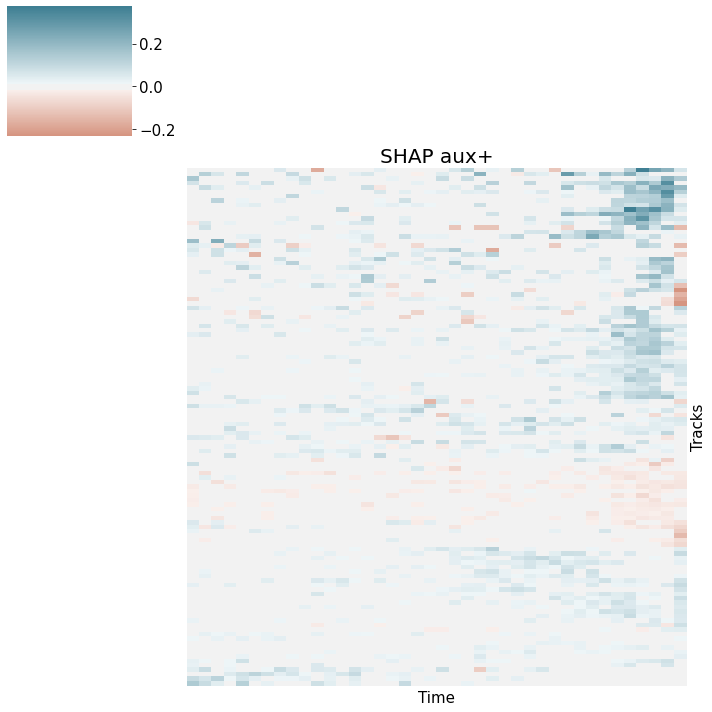

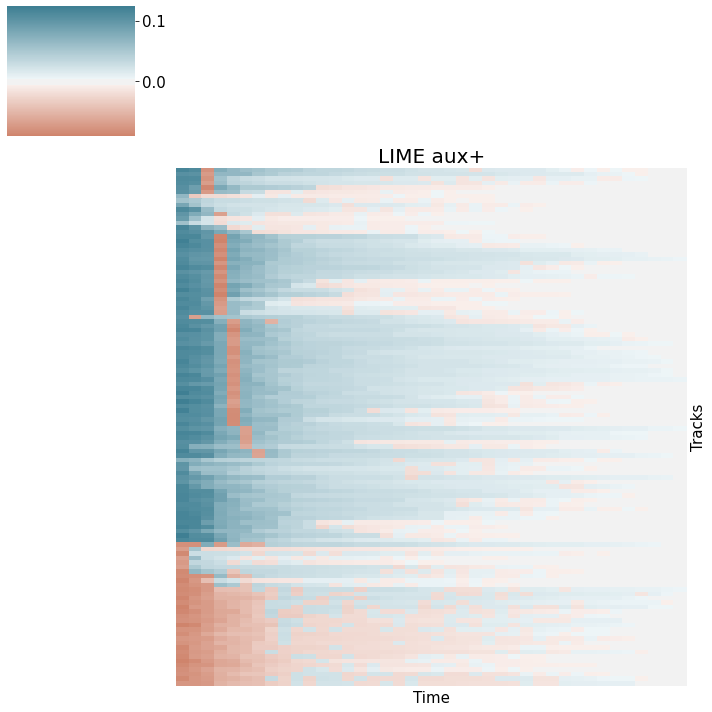

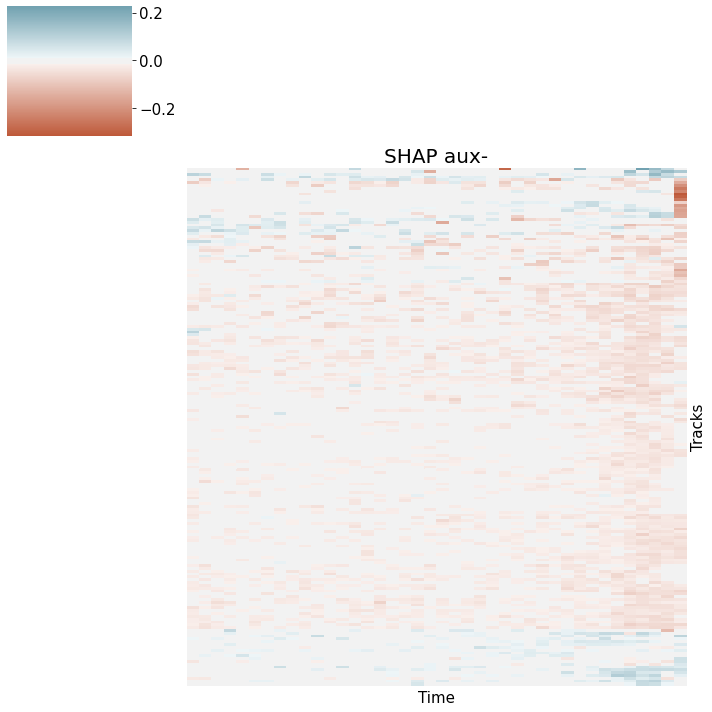

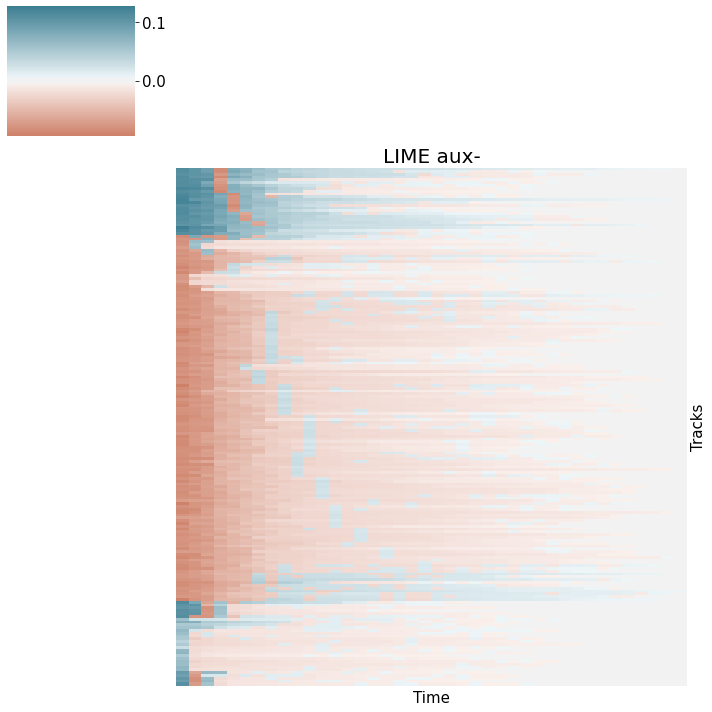

In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
        name='orange-blue', 
        colors=[(222/255, 85/255, 51/255),
                'lightgray',
                (50/255, 129/255, 168/255)]
    )

# plot clustermap
vabs=0.3
for neg in [False, True]:
    for k in ['shap', 'lime']:
        cm = sns.diverging_palette(22, 220, as_cmap=True, center='light')
        idxs = y[:NUM_EXAMPLES]
        if neg:
            idxs = ~idxs
        cg = sns.clustermap(scores[k][idxs], col_cluster=False, cmap=cm, center=0,
                            norm=matplotlib.colors.Normalize(vmin=-vabs, vmax=vabs))
        cg.ax_row_dendrogram.set_visible(False)
        hm = cg.ax_heatmap
        hm.set_xlabel('Time')
        hm.set_ylabel('Tracks')
        hm.set_yticks([])
        hm.set_xticks([])
        s = 'aux-' if neg else 'aux+'
        hm.set_title(k.upper() + ' ' + s)
        viz.savefig(f'heatmap_{k}_{s}', png=False)
        # plt.xticks(np.arange(0, 40, 2), xticklabels=[])
#         plt.suptitle("A", y=1.1, fontweight='bold')
        plt.tight_layout()
plt.show()

# global feat imp

In [13]:
def perm_importance(X, model, feat_names):
    '''custom bc some features are lists (e.g. the track)'''
    acc_orig = np.mean((dnn.predict(X) > 0) == y)
    imps = {feat_name: [] for feat_name in feat_names}
    reps = 3
    for feat_name in tqdm(feat_names):
        for r in range(reps):
            X_copy = deepcopy(X)
            X_copy[feat_name] = np.random.permutation(X_copy[feat_name].values)
            acc = np.mean((dnn.predict(X_copy) > 0) == y)
            imps[feat_name].append(acc_orig - acc)
    return pd.DataFrame.from_dict(imps).mean().sort_values(ascending=False)

np.random.seed(13)
imps = perm_importance(X, dnn, feat_names)